In [2]:
import os

os.environ["AICORE_AUTH_URL"] = "https://btp-ai-developments-sl2f9ys4.authentication.eu10.hana.ondemand.com"
os.environ["AICORE_CLIENT_ID"] = "sb-38176009-b499-470f-a3b8-9cf98daac1d0!b503699|aicore!b540"
os.environ["AICORE_CLIENT_SECRET"] = "1ac5c77f-d5ac-4e2d-8c19-6ffc47113ec8$52U4q9NYAN-GBm23a2lm_SFVrzmWNhuS7l_qFXs4s4A="
os.environ["AICORE_BASE_URL"] = "https://api.ai.prod.eu-central-1.aws.ml.hana.ondemand.com"
os.environ["AICORE_RESOURCE_GROUP"]="default"

from flask import Flask, request, jsonify
from langchain_community.utilities import SQLDatabase
from sqlalchemy import create_engine,inspect,text
from langchain.chains import create_sql_query_chain
import pandas as pd
import re
from langchain_experimental.agents.agent_toolkits import create_pandas_dataframe_agent
from flask_cors import CORS
import json
import base64

import platform
from hdbcli import dbapi


from sqlalchemy import create_engine, inspect
from sqlalchemy.engine.url import URL
from langchain_community.utilities import SQLDatabase


from langchain_core.language_models import LLM
from langchain_core.outputs import Generation, LLMResult
from typing import List, Optional, Any
from gen_ai_hub.proxy.native.openai import chat
from gen_ai_hub.proxy.langchain.init_models import init_llm



Supervisor is a multi-agent architecture where specialized agents are coordinated by a central supervisor agent. The supervisor agent controls all communication flow and task delegation, making decisions about which agent to invoke based on the current context and task requirements.
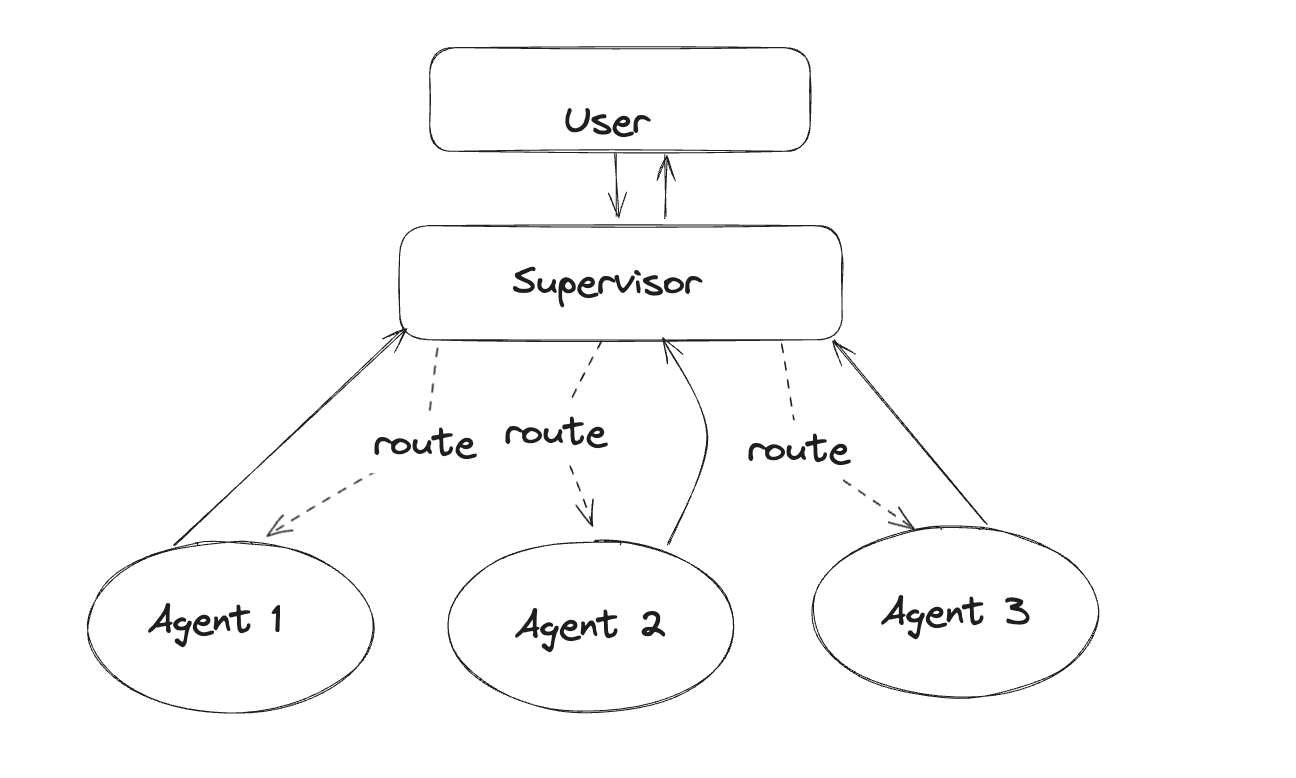

#### Create Worker Agent : SQL agent - which will soley perform SQL opertation on data and report it back to supervisor agent 

In [3]:
schema_name = "INVTRISK"

# Build the connection URL manually
connection_url = URL.create(
    drivername="hana",  # NOT hana+hana
    username="DBADMIN",
    password="Bcone@1234567",
    host="cfe32093-429a-4e59-87dc-9f3e4da891bf.hna2.prod-eu10.hanacloud.ondemand.com",
    port=443,
    query={
        "encrypt": "true",
        "sslValidateCertificate": "false",
        "currentSchema": schema_name
    }
)

# Create engine
engine = create_engine(connection_url)

# Inspect
inspector = inspect(engine)
tables = inspector.get_table_names(schema=schema_name)

# Get the db variable as before
db = SQLDatabase(engine=engine, schema=schema_name, include_tables=tables)


In [4]:
from gen_ai_hub.proxy.langchain.init_models import init_llm
llm = init_llm('gpt-4o', max_tokens=4096, temperature = 0)

from langchain_community.agent_toolkits import SQLDatabaseToolkit
toolkit = SQLDatabaseToolkit(db=db, llm=llm, top_k = 100)
tools = toolkit.get_tools()
tools

[QuerySQLDatabaseTool(description="Input to this tool is a detailed and correct SQL query, output is a result from the database. If the query is not correct, an error message will be returned. If an error is returned, rewrite the query, check the query, and try again. If you encounter an issue with Unknown column 'xxxx' in 'field list', use sql_db_schema to query the correct table fields.", db=<langchain_community.utilities.sql_database.SQLDatabase object at 0x7f0cc30e5910>),
 InfoSQLDatabaseTool(description='Input to this tool is a comma-separated list of tables, output is the schema and sample rows for those tables. Be sure that the tables actually exist by calling sql_db_list_tables first! Example Input: table1, table2, table3', db=<langchain_community.utilities.sql_database.SQLDatabase object at 0x7f0cc30e5910>),
 ListSQLDatabaseTool(db=<langchain_community.utilities.sql_database.SQLDatabase object at 0x7f0cc30e5910>),
 QuerySQLCheckerTool(description='Use this tool to double check

In [5]:
dialect="SQLite"
top_k=100
table_name = "stock_status"
system_message = f"""
You are an agent designed to interact with a SQL database working with a supply chain planning table named **{table_name}** 
This table tracks weekly stock status for various products at different plants and distribution centers.
Here are the column definitions :
- Column Name (Data Type): column description
- product_id(varchar): Unique identifier of the product (e.g., FG-1000, FG-2000).
- location_id(varchar): Identifier of the distribution center (e.g., DC1000, RDC1000).
- week_num(integer): An integer (1-52) representing the ISO week number of the year.
- week_end_date (date): Date (ISO format) representing the last day (typically Sunday) of the given week_num and year.
- quarter (varchar): Calendar quarter (e.g., Q1, Q2) corresponding to the week_end_date.
- month (varchar): Full month name (e.g., January, February) derived from the week_end_date.
- year (integer): Four-digit calendar year associated with the week_num.
- stock_condition (varchar): Indicates the comparison between projected_stock and safety_stock.
Values:
excess: when projected_stock > safety_stock
deficit: when projected_stock < safety_stock
in-stock: when projected_stock == safety_stock
- stock_status_warning (varchar): Alerts when 4 or more consecutive weeks of excess or deficit are detected for a given product_id, location_id, and location_type.
Values:
normal: No warning condition detected
overstock_instance_N: Nth occurrence of a prolonged excess stock condition
understock_instance_N: Nth occurrence of a prolonged deficit stock condition
In response, keep in mind to mention Nth occurrence of condition only once 
While responding with instance occurrence, always specify its location and the period range of instance(Always use week_end_date for precise instance period caluclation ) 
and don't mention instances verbatum (like overstock_instance_1) , mention it in more natural laguage format.

Given an input question, create a syntactically correct {dialect} query to run,
then look at the results of the query and return the answer. Unless the user
specifies a specific number of examples they wish to obtain, always atleast provide limit your
query to at most {top_k} results.

You can order the results by a relevant column to return the most interesting
examples in the database. Never query for all the columns from a specific table,
only ask for the relevant columns given the question.

You MUST double check your query before executing it. If you get an error while
executing a query, rewrite the query and try again.
While writing query keep in mind that query will be ran on SAP HANA SQL console, so adjust the query accordingly.

SQL query instructions
Make sure to qualify column names with their respective table names.
Similarly, Make sure to qualify table names with their respective Schema names.
Include all columns names in select statment which are present in join, where and order by clause
This will ensure the relevant identifier is retrieved along with the other requested data.
CHARINDEX doesn't work ,so instead use INSTR() is the correct function.
DO NOT make any DML statements (INSERT, UPDATE, DELETE, DROP etc.) to the
database.

To start you should ALWAYS look at the tables in the database to see what you
can query. Do NOT skip this step.

Then you should query the schema of the most relevant tables.

"""

In [6]:
from langchain_core.messages import HumanMessage
from langgraph.prebuilt import create_react_agent

sql_agent_executor = create_react_agent(llm, tools, prompt=system_message,   name="sql_agent_executor")

In [7]:
#!pip install langgraph


In [8]:
# Creating RAG agent
from gen_ai_hub.proxy.langchain.init_models import init_llm
llm = init_llm('gpt-4o', max_tokens=4096, temperature = 0)

from langchain_community.document_loaders import UnstructuredWordDocumentLoader
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_community.vectorstores import Chroma
from langchain.embeddings import OpenAIEmbeddings  # Or any compatible embedding
from gen_ai_hub.proxy.langchain.init_models import init_embedding_model

# Load .doc file
loader = UnstructuredWordDocumentLoader("rules_and_explanations.docx")
documents = loader.load()

# Split into chunks
splitter = RecursiveCharacterTextSplitter(chunk_size=500, chunk_overlap=50)
docs = splitter.split_documents(documents)

# Step 3: Initialize SAP-compatible embedding
# Step 3: Use local HuggingFace embedding model
embeddings = init_embedding_model('text-embedding-ada-002')# Use available embedding on GenAI Hub

# Step 4: Create and persist vector store
vectorstore = Chroma.from_documents(docs, embeddings, persist_directory="./chroma_store")
vectorstore.persist()


/tmp/ipykernel_3937/1410052031.py:25: LangChainDeprecationWarning: Since Chroma 0.4.x the manual persistence method is no longer supported as docs are automatically persisted.
  vectorstore.persist()


In [9]:
#!pip install chromadb
#!pip install pydantic==2.9.0
#!pip install langgraph-supervisor

In [10]:
from langchain.tools import Tool
from langchain.chains import RetrievalQA
from langchain_core.language_models import LLM

# Reuse your LLM
retriever = vectorstore.as_retriever(search_kwargs={"k": 5})

rag_chain = RetrievalQA.from_chain_type(llm=llm, retriever=retriever)

rag_tool = Tool(
    name="rag_retriever",
    func=rag_chain.run,
    description="Use this to retrieve information and answer queries from rules and explanations in a document."
)

# Tools list for the agent
rag_tools = [rag_tool]


In [11]:
#system_message_rag = """ You are working"""

In [12]:
from langgraph.prebuilt import create_react_agent

rag_agent_executor = create_react_agent(
    llm,
    rag_tools,
    #prompt=system_message_rag,  # Reuse your system message or customize for RAG
    name="rag_agent_executor"
)


In [13]:
from langgraph_supervisor import create_supervisor
from langchain.chat_models import init_chat_model

supervisor = create_supervisor(
    model=llm,
    agents=[sql_agent_executor,rag_agent_executor],
    prompt=(
        "You are a supervisor managing two agents to inform user regarding overstock and undertsock of products happening in the supply chain network\n"
        "Your task is to answer query using the two agents: \n"
        "- sql_agent_executor agent: to be used for data extraction related task from SQL database\n"
        "- rag_agent_executor agent: to be used for rules and reasoning extraction related task, as the agent has access to domain supply chain business rules and reasoning for status\n"
        "Think step by step on breaking the user queries in small actionable plan\n"
        "Then sequentially assign it to agents to get the answers for each step to conclude on final answer\n"
        "Assign work to one agent at a time, do not call agents in parallel.\n"
        "After getting results from one agent, always try if any more information enrichment can be done can be done using other agent.\n"
        "Do not do any work yourself.\n"
    ),
    add_handoff_back_messages=True,
    output_mode="full_history"
).compile()

In [14]:
#!pip install langgraph-supervisor

In [15]:
from langchain_core.messages import convert_to_messages


def pretty_print_message(message, indent=False):
    pretty_message = message.pretty_repr(html=True)
    if not indent:
        print(pretty_message)
        return

    indented = "\n".join("\t" + c for c in pretty_message.split("\n"))
    print(indented)


def pretty_print_messages(update, last_message=False):
    is_subgraph = False
    if isinstance(update, tuple):
        ns, update = update
        # skip parent graph updates in the printouts
        if len(ns) == 0:
            return

        graph_id = ns[-1].split(":")[0]
        print(f"Update from subgraph {graph_id}:")
        print("\n")
        is_subgraph = True

    for node_name, node_update in update.items():
        update_label = f"Update from node {node_name}:"
        if is_subgraph:
            update_label = "\t" + update_label

        print(update_label)
        print("\n")

        messages = convert_to_messages(node_update["messages"])
        if last_message:
            messages = messages[-1:]

        for m in messages:
            pretty_print_message(m, indent=is_subgraph)
        print("\n")

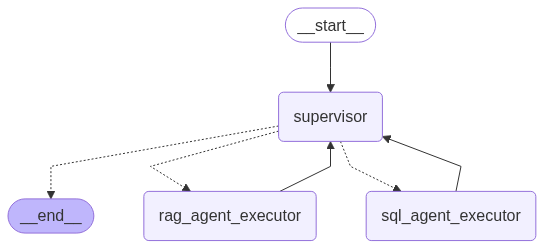

In [16]:
from IPython.display import display, Image

display(Image(supervisor.get_graph().draw_mermaid_png()))

In [ ]:
question = "Are there any warning instances for stock for Product FG-1000?"

for step in supervisor.stream(
    {"messages": [{"role": "user", "content": question}]},
    stream_mode="debug",
):
    print(step)

{'step': 1, 'timestamp': '2025-07-11T04:58:29.968983+00:00', 'type': 'task', 'payload': {'id': '6c5dd33e-5ea9-baf8-c042-a484ecc65d87', 'name': 'supervisor', 'input': {'messages': [HumanMessage(content='Are there any warning instances for stock for Product FG-1000?', additional_kwargs={}, response_metadata={}, id='ebe34fb4-a2e0-4b6d-baf1-31210a89044e')], 'is_last_step': False, 'remaining_steps': 24}, 'triggers': ('branch:to:supervisor',)}}


Task supervisor with path ('__pregel_pull', 'supervisor') wrote to unknown channel is_last_step, ignoring it.
Task supervisor with path ('__pregel_pull', 'supervisor') wrote to unknown channel remaining_steps, ignoring it.


{'step': 1, 'timestamp': '2025-07-11T04:58:30.485122+00:00', 'type': 'task_result', 'payload': {'id': '6c5dd33e-5ea9-baf8-c042-a484ecc65d87', 'name': 'supervisor', 'error': None, 'result': [('messages', [HumanMessage(content='Are there any warning instances for stock for Product FG-1000?', additional_kwargs={}, response_metadata={}, id='ebe34fb4-a2e0-4b6d-baf1-31210a89044e'), AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_hZY2hHzdFTMWG3TUdZsNLJvL', 'function': {'arguments': '{}', 'name': 'transfer_to_sql_agent_executor'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 14, 'prompt_tokens': 607, 'total_tokens': 621, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_ee1d74bde0', 'id': 'chatcmpl-Bs086i2MF7V

Task supervisor with path ('__pregel_pull', 'supervisor') wrote to unknown channel is_last_step, ignoring it.
Task supervisor with path ('__pregel_pull', 'supervisor') wrote to unknown channel remaining_steps, ignoring it.


{'step': 3, 'timestamp': '2025-07-11T04:58:36.316734+00:00', 'type': 'task_result', 'payload': {'id': 'a3790189-1471-83e2-54b3-d518481b8149', 'name': 'supervisor', 'error': None, 'result': [('messages', [HumanMessage(content='Are there any warning instances for stock for Product FG-1000?', additional_kwargs={}, response_metadata={}, id='ebe34fb4-a2e0-4b6d-baf1-31210a89044e'), AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_hZY2hHzdFTMWG3TUdZsNLJvL', 'function': {'arguments': '{}', 'name': 'transfer_to_sql_agent_executor'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 14, 'prompt_tokens': 607, 'total_tokens': 621, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_ee1d74bde0', 'id': 'chatcmpl-Bs086i2MF7V

In [17]:
for chunk in supervisor.stream(
    {
        "messages": [
            {
                "role": "user",
                "content": "Are there any warning instances for stock for Product FG-1000?",
            }
        ]
    },
):
    pretty_print_messages(chunk, last_message=True)

final_message_history = chunk["supervisor"]["messages"]

Task supervisor with path ('__pregel_pull', 'supervisor') wrote to unknown channel is_last_step, ignoring it.
Task supervisor with path ('__pregel_pull', 'supervisor') wrote to unknown channel remaining_steps, ignoring it.


Update from node supervisor:


================================= Tool Message =================================
Name: transfer_to_sql_agent_executor

Successfully transferred to sql_agent_executor


Update from node sql_agent_executor:


================================= Tool Message =================================
Name: transfer_back_to_supervisor

Successfully transferred back to supervisor




Task supervisor with path ('__pregel_pull', 'supervisor') wrote to unknown channel is_last_step, ignoring it.
Task supervisor with path ('__pregel_pull', 'supervisor') wrote to unknown channel remaining_steps, ignoring it.


Update from node supervisor:


================================= Tool Message =================================
Name: transfer_to_rag_agent_executor

Successfully transferred to rag_agent_executor


Update from node rag_agent_executor:


================================= Tool Message =================================
Name: transfer_back_to_supervisor

Successfully transferred back to supervisor


Update from node supervisor:


================================== Ai Message ==================================
Name: supervisor

For Product FG-1000, there are several warning instances related to stock conditions:

1. **Overstock Warning**:
   - **Location DC1000**: The first occurrence of overstock was detected from June 1, 2025, to July 13, 2025.
   - **Location DC2000**: The first occurrence of overstock was detected from June 1, 2025, to July 20, 2025.
   - **Location RDC1000**: The first occurrence of overstock was detected from June 29, 2025, to November 23, 2025.

2. **Understock Warn

In [14]:
question = "Are there any warning instances for stock for Product FG-1000?"

for step in supervisor.stream(
    {"messages": [{"role": "user", "content": question}]},
    stream_mode="values",
):
    step["messages"][-1].pretty_print()

================================ Human Message =================================

Are there any warning instances for stock for Product FG-1000?


Task supervisor with path ('__pregel_pull', 'supervisor') wrote to unknown channel is_last_step, ignoring it.
Task supervisor with path ('__pregel_pull', 'supervisor') wrote to unknown channel remaining_steps, ignoring it.


================================= Tool Message =================================
Name: transfer_to_sql_agent_executor

Successfully transferred to sql_agent_executor
================================= Tool Message =================================
Name: transfer_back_to_supervisor

Successfully transferred back to supervisor


Task supervisor with path ('__pregel_pull', 'supervisor') wrote to unknown channel is_last_step, ignoring it.
Task supervisor with path ('__pregel_pull', 'supervisor') wrote to unknown channel remaining_steps, ignoring it.


================================= Tool Message =================================
Name: transfer_to_rag_agent_executor

Successfully transferred to rag_agent_executor
================================= Tool Message =================================
Name: transfer_back_to_supervisor

Successfully transferred back to supervisor
================================== Ai Message ==================================
Name: supervisor

For Product FG-1000, the warning instances related to stock conditions are as follows:

### Overstock Condition:
- **High Initial Stock**: Overstock is primarily caused by a high amount of stock on hand at the start of the period.
- **Supply Chain Mismanagement**: If the 'stock on hand' value is missing for the first week, the overstock is attributed to supply chain mismanagement.

### Understock Condition:
- **Demand vs. Production**: The total demand for Product FG-1000 is 48,000 units, while the total production is only 40,000 units, leading to an understock conditi

In [18]:
question = "What is the reason for the first overstock instance for product FG-1000 at location DC1000? Provide evidence with values for the reason."

for step in supervisor.stream(
    {"messages": [{"role": "user", "content": question}]},
    stream_mode="values",
):
    step["messages"][-1].pretty_print()

================================ Human Message =================================

What is the reason for the first overstock instance for product FG-1000 at location DC1000? Provide evidence with values for the reason.


Task supervisor with path ('__pregel_pull', 'supervisor') wrote to unknown channel is_last_step, ignoring it.
Task supervisor with path ('__pregel_pull', 'supervisor') wrote to unknown channel remaining_steps, ignoring it.


================================= Tool Message =================================
Name: transfer_to_sql_agent_executor

Successfully transferred to sql_agent_executor
================================= Tool Message =================================
Name: transfer_back_to_supervisor

Successfully transferred back to supervisor


Task supervisor with path ('__pregel_pull', 'supervisor') wrote to unknown channel is_last_step, ignoring it.
Task supervisor with path ('__pregel_pull', 'supervisor') wrote to unknown channel remaining_steps, ignoring it.


================================= Tool Message =================================
Name: transfer_to_rag_agent_executor

Successfully transferred to rag_agent_executor
================================= Tool Message =================================
Name: transfer_back_to_supervisor

Successfully transferred back to supervisor
================================== Ai Message ==================================
Name: supervisor

The first overstock instance for product FG-1000 at location DC1000 occurred in the week ending on June 1, 2025. The reason for this overstock condition was that the stock on hand was 3100 units, which significantly exceeded the safety stock level of 112 units. This discrepancy between the stock on hand and the safety stock is the reason for the overstock instance.


In [ ]:
question = "What is the reason for the first undertsock instance for product FG-1000 at location DC1000?Provide evidence with values for the reason."

for step in supervisor.stream(
    {"messages": [{"role": "user", "content": question}]},
    stream_mode="values",
):
    step["messages"][-1].pretty_print()

================================ Human Message =================================

What is the reason for the first undertsock instance for product FG-1000 at location DC1000?Provide evidence with values for the reason.


Task supervisor with path ('__pregel_pull', 'supervisor') wrote to unknown channel is_last_step, ignoring it.
Task supervisor with path ('__pregel_pull', 'supervisor') wrote to unknown channel remaining_steps, ignoring it.


================================= Tool Message =================================
Name: transfer_to_sql_agent_executor

Successfully transferred to sql_agent_executor
================================= Tool Message =================================
Name: transfer_back_to_supervisor

Successfully transferred back to supervisor


Task supervisor with path ('__pregel_pull', 'supervisor') wrote to unknown channel is_last_step, ignoring it.
Task supervisor with path ('__pregel_pull', 'supervisor') wrote to unknown channel remaining_steps, ignoring it.


================================= Tool Message =================================
Name: transfer_to_rag_agent_executor

Successfully transferred to rag_agent_executor
================================= Tool Message =================================
Name: transfer_back_to_supervisor

Successfully transferred back to supervisor


Task supervisor with path ('__pregel_pull', 'supervisor') wrote to unknown channel is_last_step, ignoring it.
Task supervisor with path ('__pregel_pull', 'supervisor') wrote to unknown channel remaining_steps, ignoring it.


================================= Tool Message =================================
Name: transfer_to_sql_agent_executor

Successfully transferred to sql_agent_executor
================================= Tool Message =================================
Name: transfer_back_to_supervisor

Successfully transferred back to supervisor
================================== Ai Message ==================================
Name: supervisor

The first understock instance for product FG-1000 at location DC1000 occurred on January 4, 2026, due to a deficit in stock condition. The reason for this understock can be attributed to either:

1. **Demand exceeding capacity**: If the production capacity was unable to meet the demand for FG-1000, this would be the primary reason for the understock.

2. **Supply chain mismanagement**: If the production capacity was sufficient but the understock still occurred, it indicates issues within the supply chain management.

Unfortunately, the query to compare the demand and p

In [54]:
question = "Do we have any stock warnings in the month of jun-25?"

for step in supervisor.stream(
    {"messages": [{"role": "user", "content": question}]},
    stream_mode="values",
):
    step["messages"][-1].pretty_print()

================================ Human Message =================================

Do we have any stock warnings in the month of jun-25?


Task supervisor with path ('__pregel_pull', 'supervisor') wrote to unknown channel is_last_step, ignoring it.
Task supervisor with path ('__pregel_pull', 'supervisor') wrote to unknown channel remaining_steps, ignoring it.


================================= Tool Message =================================
Name: transfer_to_sql_agent_executor

Successfully transferred to sql_agent_executor
================================= Tool Message =================================
Name: transfer_back_to_supervisor

Successfully transferred back to supervisor
================================== Ai Message ==================================
Name: supervisor

In June 2025, there are stock warnings indicating overstock situations for product FG-1000 at various locations:

1. At location DC1000, there is a prolonged overstock condition from June 1st to June 29th, 2025.
2. At location DC2000, the same overstock condition is observed from June 1st to June 29th, 2025.
3. At location RDC1000, the overstock condition is noted on June 29th, 2025.

These warnings suggest that there is an overstock situation for product FG-1000 across multiple locations during June 2025.


In [56]:
question = "What is the reason for overstock in month of jun-25 at location DC2000?"

for step in supervisor.stream(
    {"messages": [{"role": "user", "content": question}]},
    stream_mode="values",
):
    step["messages"][-1].pretty_print()

================================ Human Message =================================

What is the reason for overstock in month of jun-25 at location DC2000?


Task supervisor with path ('__pregel_pull', 'supervisor') wrote to unknown channel is_last_step, ignoring it.
Task supervisor with path ('__pregel_pull', 'supervisor') wrote to unknown channel remaining_steps, ignoring it.


================================= Tool Message =================================
Name: transfer_to_sql_agent_executor

Successfully transferred to sql_agent_executor
================================= Tool Message =================================
Name: transfer_back_to_supervisor

Successfully transferred back to supervisor


Task supervisor with path ('__pregel_pull', 'supervisor') wrote to unknown channel is_last_step, ignoring it.
Task supervisor with path ('__pregel_pull', 'supervisor') wrote to unknown channel remaining_steps, ignoring it.


================================= Tool Message =================================
Name: transfer_to_rag_agent_executor

Successfully transferred to rag_agent_executor
================================= Tool Message =================================
Name: transfer_back_to_supervisor

Successfully transferred back to supervisor
================================== Ai Message ==================================
Name: supervisor

The overstock situation at location DC2000 in June 2025 is primarily due to excess stock conditions for the product FG-1000. The projected stock levels were significantly higher than the safety stock levels, leading to an excess stock condition.

Possible reasons for this excess stock condition include:

1. **High Stock on Hand at the Start of the Period**: There was a high amount of stock on hand at the beginning of the period, which contributed to the overstock situation.

2. **Supply Chain Mismanagement**: The absence of 'stock on hand' values for some weeks suggest